### The Emergence of Cooperation in the Spatial Prisoner's Dilemma and Snowdrift Dilemma
Noah Rivkin and Changjun Lim

In [3]:
import networkx as nx
import numpy as np


class SpatialNetwork():
    def __init__(self, n, k, graph_type='regular', dep = None, snowdrift=False):
        """creates spatial network"""
        self.n = n
        self.k = k
        self.dep = dep
        self.G = self.create_graph(graph_type)

    def create_graph(self, graph_type):
        if graph_type == 'lattice':
            return self.create_lattice()
        elif graph_type == 'powerlaw':
            return nx.powerlaw_cluster_graph(self.n, self.k, 0)
        elif graph_type == 'HK':
            if self.dep != None:
                return nx.powerlaw_cluster_graph(self.n, self.k, self.dep)
            else:
                return nx.powerlaw_cluster_graph(self.n, self.k, .3)
        G = self.create_regular()
        if graph_type == 'regular':
            return G
        elif graph_type == 'ER':
            return self.rewire(G, p=.3)
        elif graph_type == 'random':
            return self.rewire(G, p=1)
        else:
            raise ValueError('not a recognized graph type')

    def create_regular(self):
        """
        creates regular graph. Is a helper function for rewired graphs. Some
        code taken from/based on jupyter notebook chap3, credit to Allen Downey
        """
        G = nx.Graph()
        quo, rem = divmod(self.k, 2)
        nodes = list(range(self.n))
        G.add_nodes_from(nodes)
        G.add_edges_from(adjacent_edges(nodes, quo))
        # if k is odd, add opposite edges
        if rem:
            if self.n%2:
                msg = "Can't make a regular graph if n and k are odd."
                raise ValueError(msg)
            G.add_edges_from(opposite_edges())
        return G

    def create_lattice(self):
        """
        creates a lattice graph with n nodes that is k long
        """
        G = nx.Graph()
        nodes = list(range(self.n))
        G.add_nodes_from(nodes)
        for node in nodes:
            if node + self.k in nodes:
                G.add_edge(node, node + self.k)
            if node % self.k != (self.k-1) and node + 1 in nodes:
                G.add_edge(node, node + 1)
        return G

    def rewire(self, G, p):
        """Rewires each edge with probability `p`.
        code taken from/based on jupyter notebook chap3, credit to Allen Downey
        G: Graph
        p: float
        """
        if self.dep != None:
            p = self.dep
        nodes = set(G.nodes())
        for edge in G.edges():
            if flip(p):
                u, v = edge
                choices = nodes - {u} - set(G[u])
                new_v = np.random.choice(tuple(choices))
                G.remove_edge(u, v)
                G.add_edge(u, new_v)
        return G

    
def adjacent_edges(nodes, halfk):
    """
    code taken from/based on jupyter notebook chap3, credit to Allen Downey
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        for j in range(i+1, i+halfk+1):
            v = nodes[j % n]
            yield u, v

def opposite_edges(nodes):
    """Enumerates edges that connect opposite nodes.
    code taken from/based on jupyter notebook chap3, credit to Allen Downey
    """
    n = len(nodes)
    for i, u in enumerate(nodes):
        j = i + n//2
        v = nodes[j % n]
        yield u, v

def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

In [4]:
class Node:
    C, D = 'C', 'D'
    T, R, P, S = 3, 1, 0, 0

    def __init__(self, state: str):
        """
        node object in graph. state is C or D
        """
        self.state = state
        self.score = 0  # will hold value calculated based on prisoners dilemma

    @classmethod
    def is_cooperator_state(cls, state: str):
        return state == cls.C

    def is_cooperator(self):
        return self.is_cooperator_state(self.state)

    def add_score(self, score: int):
        self.score += score

    def reset_score(self):
        self.score = 0

    # Play a single PD with neighbors, and calculate score
    #  neighbors: The list of Node object
    def play_pd(self, neighbors):
        self.reset_score()
        for neighbor in neighbors:
            self.add_score(self.pd_score(neighbor.state))

    # play single PD
    def pd_score(self, neighbor_state: str):
        if self.is_cooperator():
            if self.is_cooperator_state(neighbor_state):
                return Node.R
            return Node.S
        else:
            if self.is_cooperator_state(neighbor_state):
                return Node.T
            return Node.P

    # Copy the state of the most successful neighbor
    def get_max_state(self, neighbors):
        neighbors.append(self)
        max_score = max([neighbor.score for neighbor in neighbors])
        self.max_state = [neighbor.state for neighbor in neighbors if neighbor.score == max_score]
    
    def update_state(self):
        self.state = self.max_state[0]
        
    @classmethod
    def change_rule(cls, T, R, P, S):
        cls.T, cls.R, cls.P, cls.S = T, R, P, S

In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np

class TestBench:
    def __init__(self, n, k, graph_type, c0, p=None, N=100, M=10):
        self.n = n # the number of nodes
        self.graph = SpatialNetwork(n, k, graph_type, dep=p).G
        self.c0 = c0 # initial cooperator ratio
        self.N = N # the number of steps
        self.M = M # the number of test
        self.ratio = list()
        self.nodes = list()
        self.initialize()
    
    def initialize(self):
        cooperators = random.sample(range(self.n), int(self.n * self.c0))
        self.nodes = [Node('C') if i in cooperators else Node('D') for i in range(self.n)]
        self.ratio = list()
    
    def step(self):
        # play a single PD
        for i in range(self.n):
            neighbor = [self.nodes[key] for key in self.graph[i]]
            self.nodes[i].play_pd(neighbor)

        # get the highest neighbors' state
        for i in range(self.n):
            neighbor = [self.nodes[key] for key in self.graph[i]]
            self.nodes[i].get_max_state(neighbor)

        # update the state
        for i in range(self.n):
            self.nodes[i].update_state()

        c_ratio = len([node for node in self.nodes if node.is_cooperator()]) / self.n
        self.ratio.append(c_ratio)
    
    def iterate(self):
        ratios = np.zeros((self.M, self.N))
        for i in range(self.M):
            self.initialize()
            for _ in range(self.N):
                self.step()
            ratios[i] = self.ratio
        self.ratio = np.average(ratios, axis=0)
            
    def draw(self):
        x = range(1, len(self.ratio)+1)
        plt.plot(x, self.ratio*100)
        plt.xlabel('time')
        plt.ylabel('% C')
        plt.ylim(0,100)
        plt.show()
        
def time_ratio_graph(n, k, graph_type, c0, N, p=None, M=10, T=1, R=0.25, P=0, S=0):
    Node.change_rule(T, R, P, S)
    bench = TestBench(n, k, graph_type, c0, p, N, M)
    bench.iterate()
    bench.draw()

The proportion of cooperators in the spatial PD with d=1(regular graph)
(Fig 2 in paper)

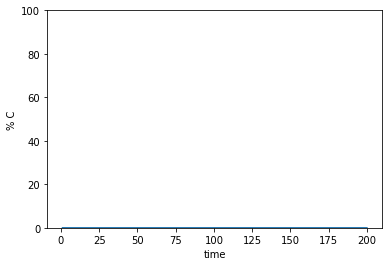

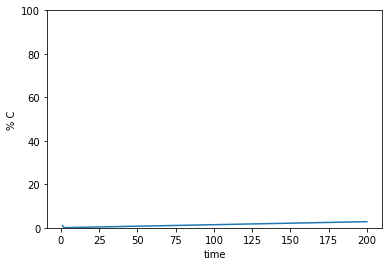

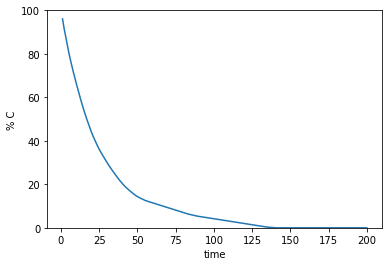

In [6]:
time_ratio_graph(n=3600, k=8, graph_type='regular', c0=0.1, N=200, M=4, T=1.1, R=1, P=0, S=0)
time_ratio_graph(n=3600, k=8, graph_type='regular', c0=0.5, N=200, M=4, T=1.7, R=1, P=0, S=0)
time_ratio_graph(n=3600, k=8, graph_type='regular', c0=0.995, N=200, M=4, T=3, R=1, P=0, S=0)

The proportion of cooperators in the spatial PD with d=2(lattice graph)
(Fig 2 in paper)

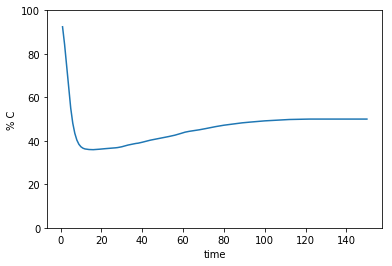

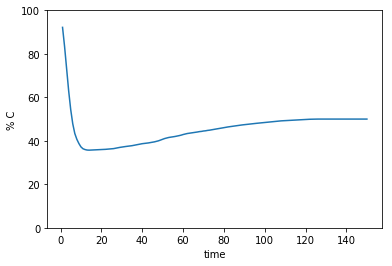

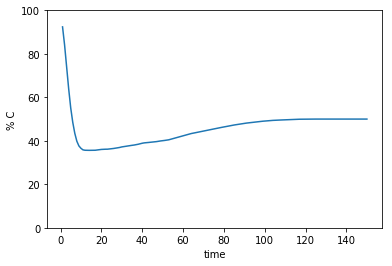

In [14]:
time_ratio_graph(n=3600, k=60, graph_type='lattice', c0=0.98, N=150, M=2, T=8, R=1, P=0, S=0)
time_ratio_graph(n=3600, k=60, graph_type='lattice', c0=0.98, N=150, M=2, T=10, R=1, P=0, S=0)
time_ratio_graph(n=3600, k=60, graph_type='lattice', c0=0.98, N=150, M=2, T=15, R=1, P=0, S=0)